# 2020 QRT Challenge

## Antoine Ratouchniak

## Used libraries

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [ ]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


# Data exploration

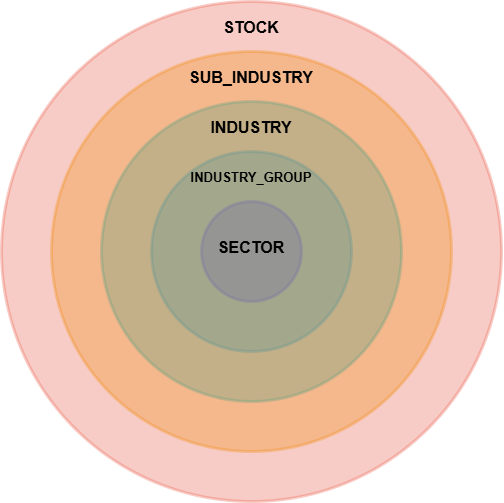
<center><b>Figure: Hierarchical Representation of Stock Classification</b></center>

The figure shows a nested classification of **stocks**, with **SECTOR** at the core as the broadest category. Moving outward, each layer refines the classification: **INDUSTRY_GROUP**, then **INDUSTRY**, followed by **SUB_INDUSTRY**, and finally **STOCK** at the outermost level.

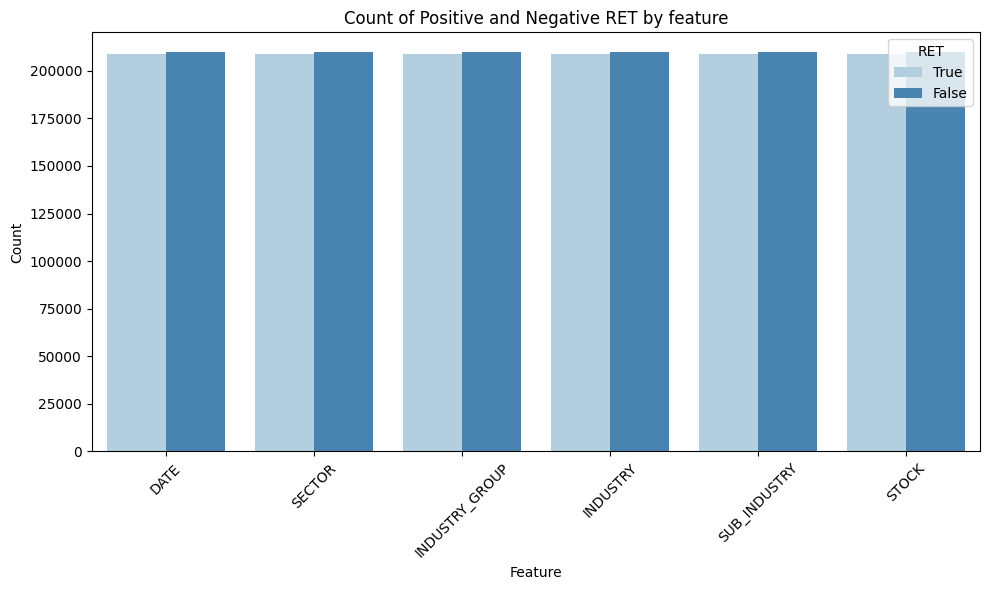

In [ ]:
categorical_features = ['DATE', 'SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY', 'SUB_INDUSTRY', 'STOCK']

feature_counts = []

for column in categorical_features:
    # Calculate the counts of True/False for each feature
    true_count = train[train['RET'] == True][column].count()
    false_count = train[train['RET'] == False][column].count()
    
    feature_counts.append({
        'Feature': column,
        'True': true_count,
        'False': false_count
    })

feature_counts_df = pd.DataFrame(feature_counts).melt(id_vars='Feature', 
                                                      value_vars=['True', 'False'], 
                                                      var_name='RET', 
                                                      value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_counts_df, x='Feature', y='Count', hue='RET', palette='Blues')

plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Count of Positive and Negative RET by feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar plot shows the distribution of positive and negative **RET** across different categorical features: **DATE**, **SECTOR**, **INDUSTRY_GROUP**, **INDUSTRY**, **SUB_INDUSTRY**, **STOCK**). The counts appear to be balanced for each feature, indicating that no single category is overwhelmingly associated with positive or negative returns.

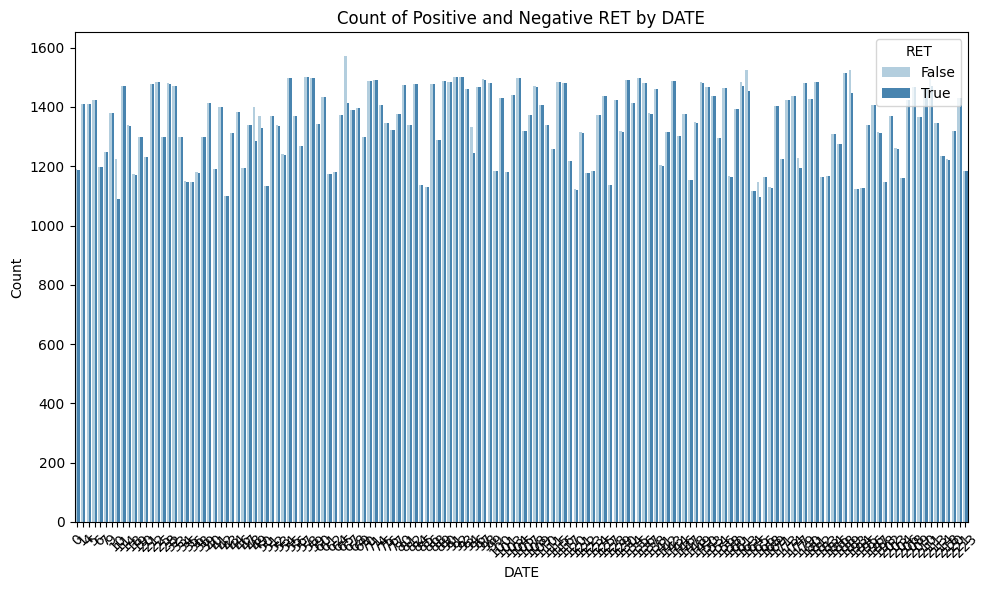

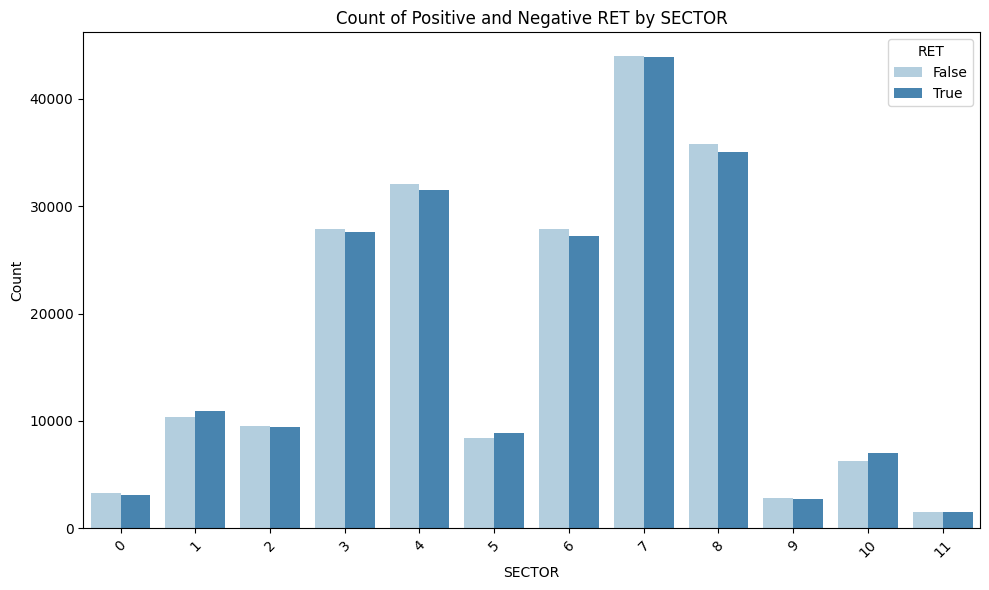

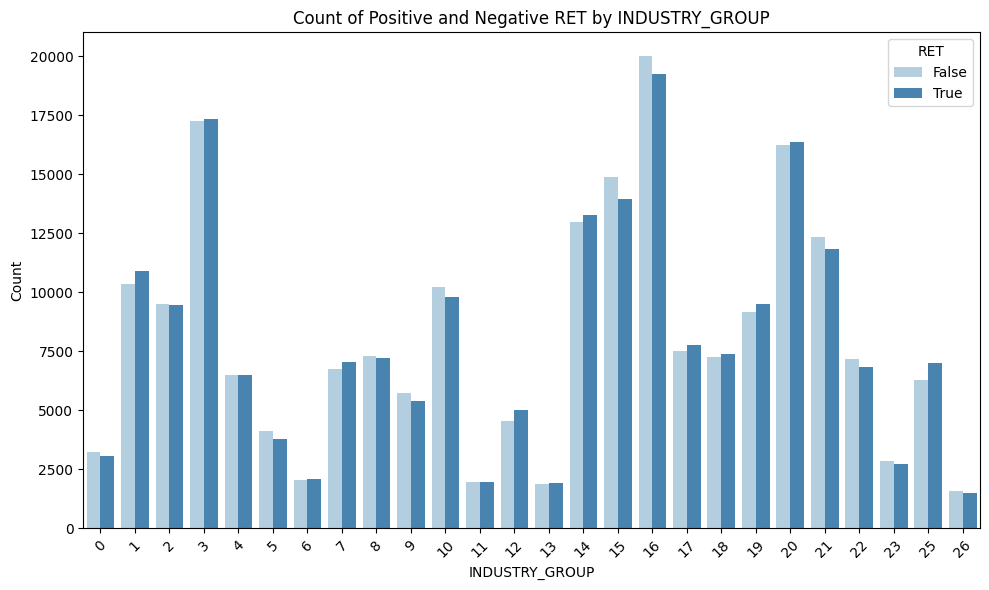

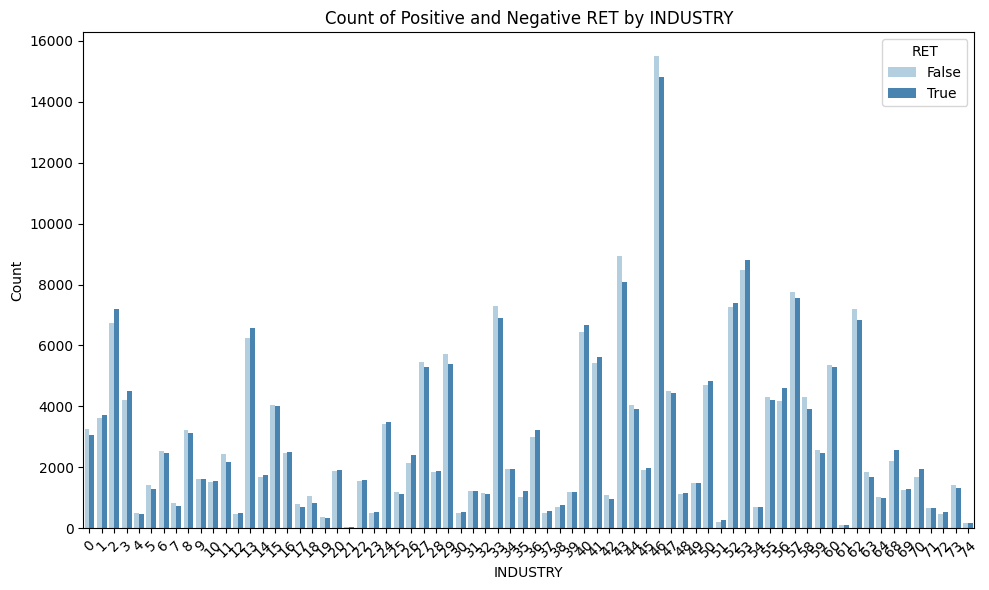

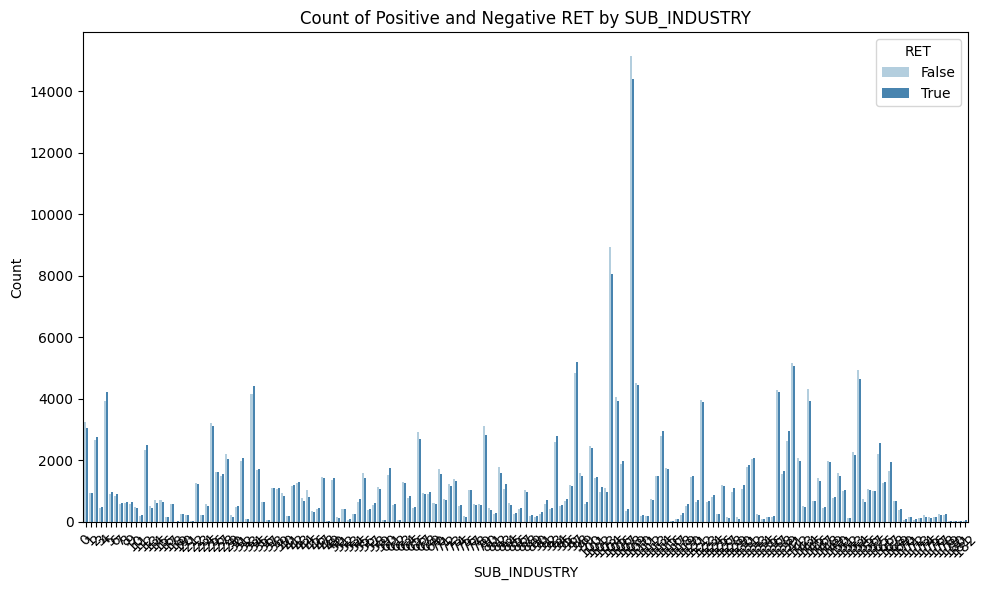

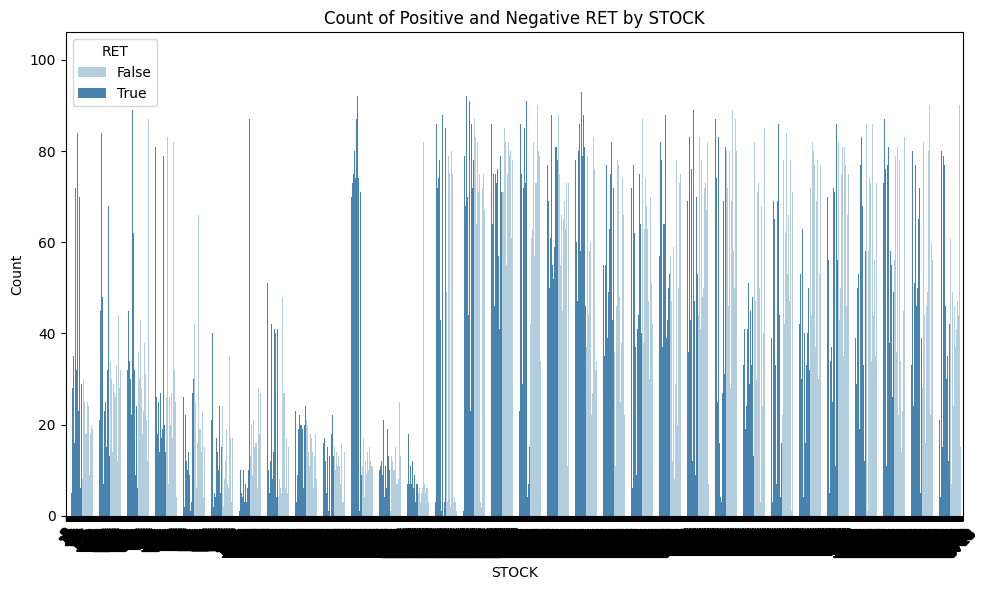

In [ ]:
for column in categorical_features:
    counts = train.groupby([column, 'RET']).size().reset_index(name='Count')
    counts['RET'] = counts['RET'].astype(str)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=counts, x=column, y='Count', hue='RET', palette='Blues')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of Positive and Negative RET by {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Expanding on our previous analysis, we observe some slight imbalance in the distribution of positive and negative **RET** values across different categorical features. The following plot a *quantitative* measure of imbalance across different categorical features using the mean imbalance ratio as $$\frac{\max(\text{class count})}{\min(\text{class count})}$$

In [ ]:
def compute_statistics(categories):
    # Calculate mean imbalance ratio for each feature
    mean_imbalance_ratios = {}
    mean_mutual_information = {}

    for column in categorical_features:
        mean_mutual_information[column] = mutual_info_classif(np.array(train[column]).reshape(-1, 1), np.array(train.RET))[0]
        imbalance_ratios = []

        for category, group in train.groupby(column):
            class_counts = group['RET'].value_counts()

            if len(class_counts) < 2:
                continue

            majority_class = class_counts.max()
            minority_class = class_counts.min()
            imbalance_ratio = majority_class / minority_class

            imbalance_ratios.append(imbalance_ratio)

        mean_imbalance_ratios[column] = np.mean(imbalance_ratios)
    
    return mean_imbalance_ratios, mean_mutual_information

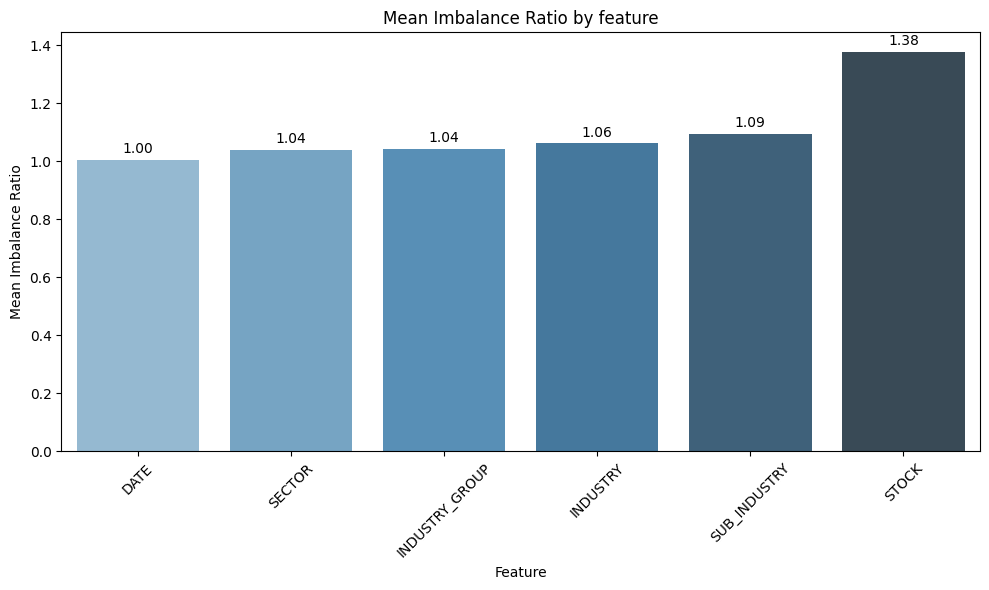

In [ ]:
mean_imbalance_ratios, mean_mutual_information = compute_statistics(categorical_features)

mean_imbalance_data = pd.DataFrame(list(mean_imbalance_ratios.items()), columns=['Feature', 'Mean Imbalance Ratio'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_imbalance_data, x='Feature', y='Mean Imbalance Ratio', palette='Blues_d')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Feature')
plt.ylabel('Mean Imbalance Ratio')
plt.title('Mean Imbalance Ratio by feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we refine categorical groupings, the imbalance ratio increases. This follows hierarchical diagram we displayed in the figure above.

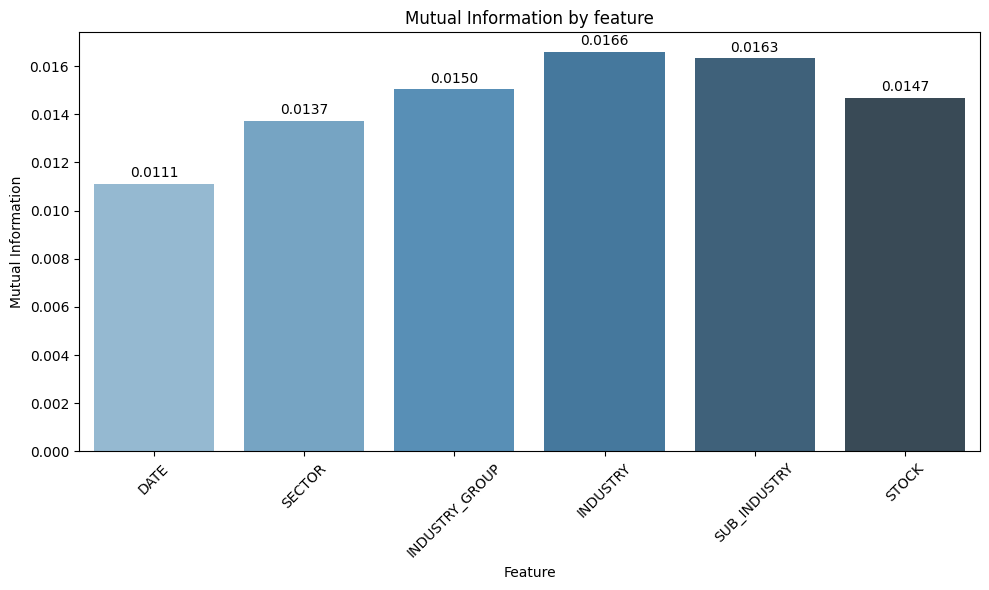

In [ ]:
mean_mutual_info_data = pd.DataFrame(list(mean_mutual_information.items()), columns=['Feature', 'Mutual Information'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_mutual_info_data, x='Feature', y='Mutual Information', palette='Blues_d')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Mutual Information by feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we plot the mutual information defined as
$$MI(X; Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log\left(\frac{p(x, y)}{p(x) p(y)}\right)$$
where:
- $p(x, y)$ is the joint probability of feature X and target Y
- $p(x)$ and $p(y)$ are marginal probabilities

Interestingly, the **INDUSTRY** has the highest mutual information, meaning it provides the most predictive power for **RET**. Similarly, the **INDUSTRY_GROUP** has a higher MI than the **STOCK**.

Next, we propose to combine different features to see if it can provide meaningful information.

In [ ]:
train['SECTOR_DATE'] = train['SECTOR'].astype(str) + '_' + train['DATE'].astype(str)
train['SECTOR_DATE_ENCODED'], unique_mapping = pd.factorize(train['SECTOR_DATE'])
train['INDUSTRY_GROUP_DATE'] = train['INDUSTRY_GROUP'].astype(str) + '_' + train['DATE'].astype(str)
train['INDUSTRY_GROUP_DATE_ENCODED'], unique_mapping = pd.factorize(train['INDUSTRY_GROUP_DATE'])
train['INDUSTRY_DATE'] = train['INDUSTRY'].astype(str) + '_' + train['DATE'].astype(str)
train['INDUSTRY_DATE_ENCODED'], unique_mapping = pd.factorize(train['INDUSTRY_DATE'])
train['SECTOR_INDUSTRY_GROUP'] = train['SECTOR'].astype(str) + '_' + train['INDUSTRY_GROUP'].astype(str)
train['SECTOR_INDUSTRY_GROUP_ENCODED'], unique_mapping = pd.factorize(train['SECTOR_INDUSTRY_GROUP'])
train['SECTOR_INDUSTRY'] = train['SECTOR'].astype(str) + '_' + train['INDUSTRY'].astype(str)
train['SECTOR_INDUSTRY_ENCODED'], unique_mapping = pd.factorize(train['SECTOR_INDUSTRY'])
train['INDUSTRY_GROUP_INDUSTRY'] = train['INDUSTRY_GROUP'].astype(str) + '_' + train['INDUSTRY'].astype(str)
train['INDUSTRY_GROUP_INDUSTRY_ENCODED'], unique_mapping = pd.factorize(train['INDUSTRY_GROUP_INDUSTRY'])

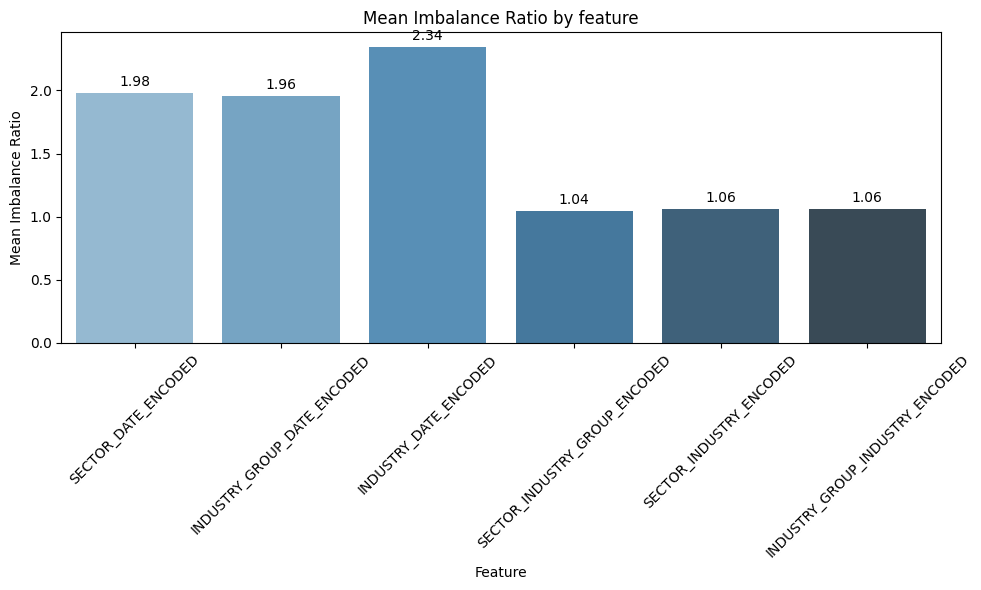

In [ ]:
categorical_features = [
    'SECTOR_DATE_ENCODED', 'INDUSTRY_GROUP_DATE_ENCODED', 'INDUSTRY_DATE_ENCODED',
    'SECTOR_INDUSTRY_GROUP_ENCODED', 'SECTOR_INDUSTRY_ENCODED', 'INDUSTRY_GROUP_INDUSTRY_ENCODED',
                       ]

mean_imbalance_ratios, mean_mutual_information = compute_statistics(categorical_features)

mean_imbalance_data = pd.DataFrame(list(mean_imbalance_ratios.items()), columns=['Feature', 'Mean Imbalance Ratio'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_imbalance_data, x='Feature', y='Mean Imbalance Ratio', palette='Blues_d')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Feature')
plt.ylabel('Mean Imbalance Ratio')
plt.title('Mean Imbalance Ratio by feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

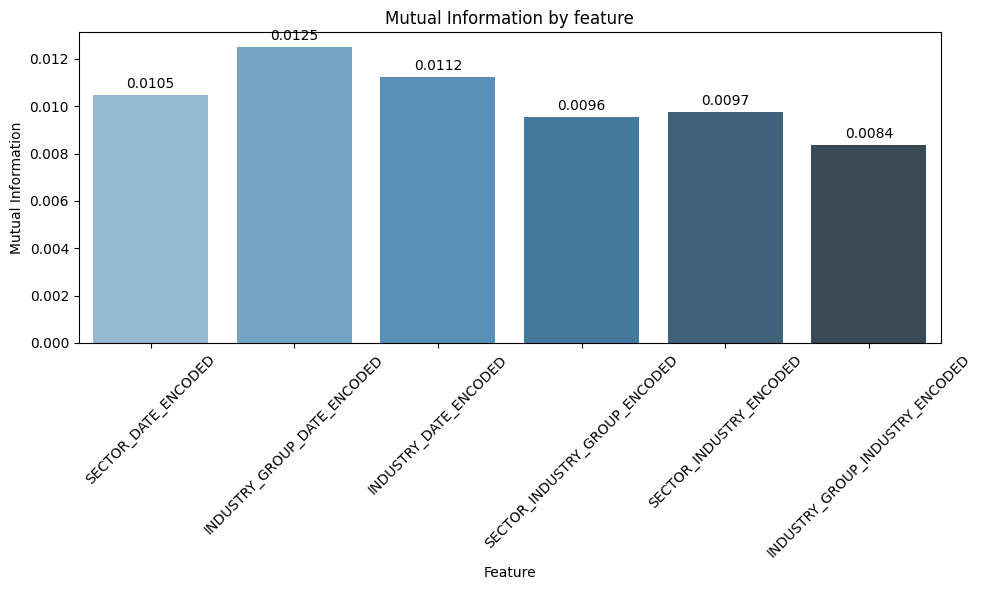

In [ ]:
mean_mutual_info_data = pd.DataFrame(list(mean_mutual_information.items()), columns=['Feature', 'Mutual Information'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_mutual_info_data, x='Feature', y='Mutual Information', palette='Blues_d')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Mutual Information by feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The first plot shows that combining **SECTOR**, **INDUSTRY_GROUP** or **INDUSTRY** with **DATE** increases the imbalance ratio, suggesting that time may have an impact on the distribution of returns. This indicates that some sectors or industries may be impacted by political news, for instance.
In the second plot, however, we do not observe any significant difference compared to the previous plot in terms of mutual information values.

We analyze the continuous features, returns and volumes, to identify potential relationships with the target variable.

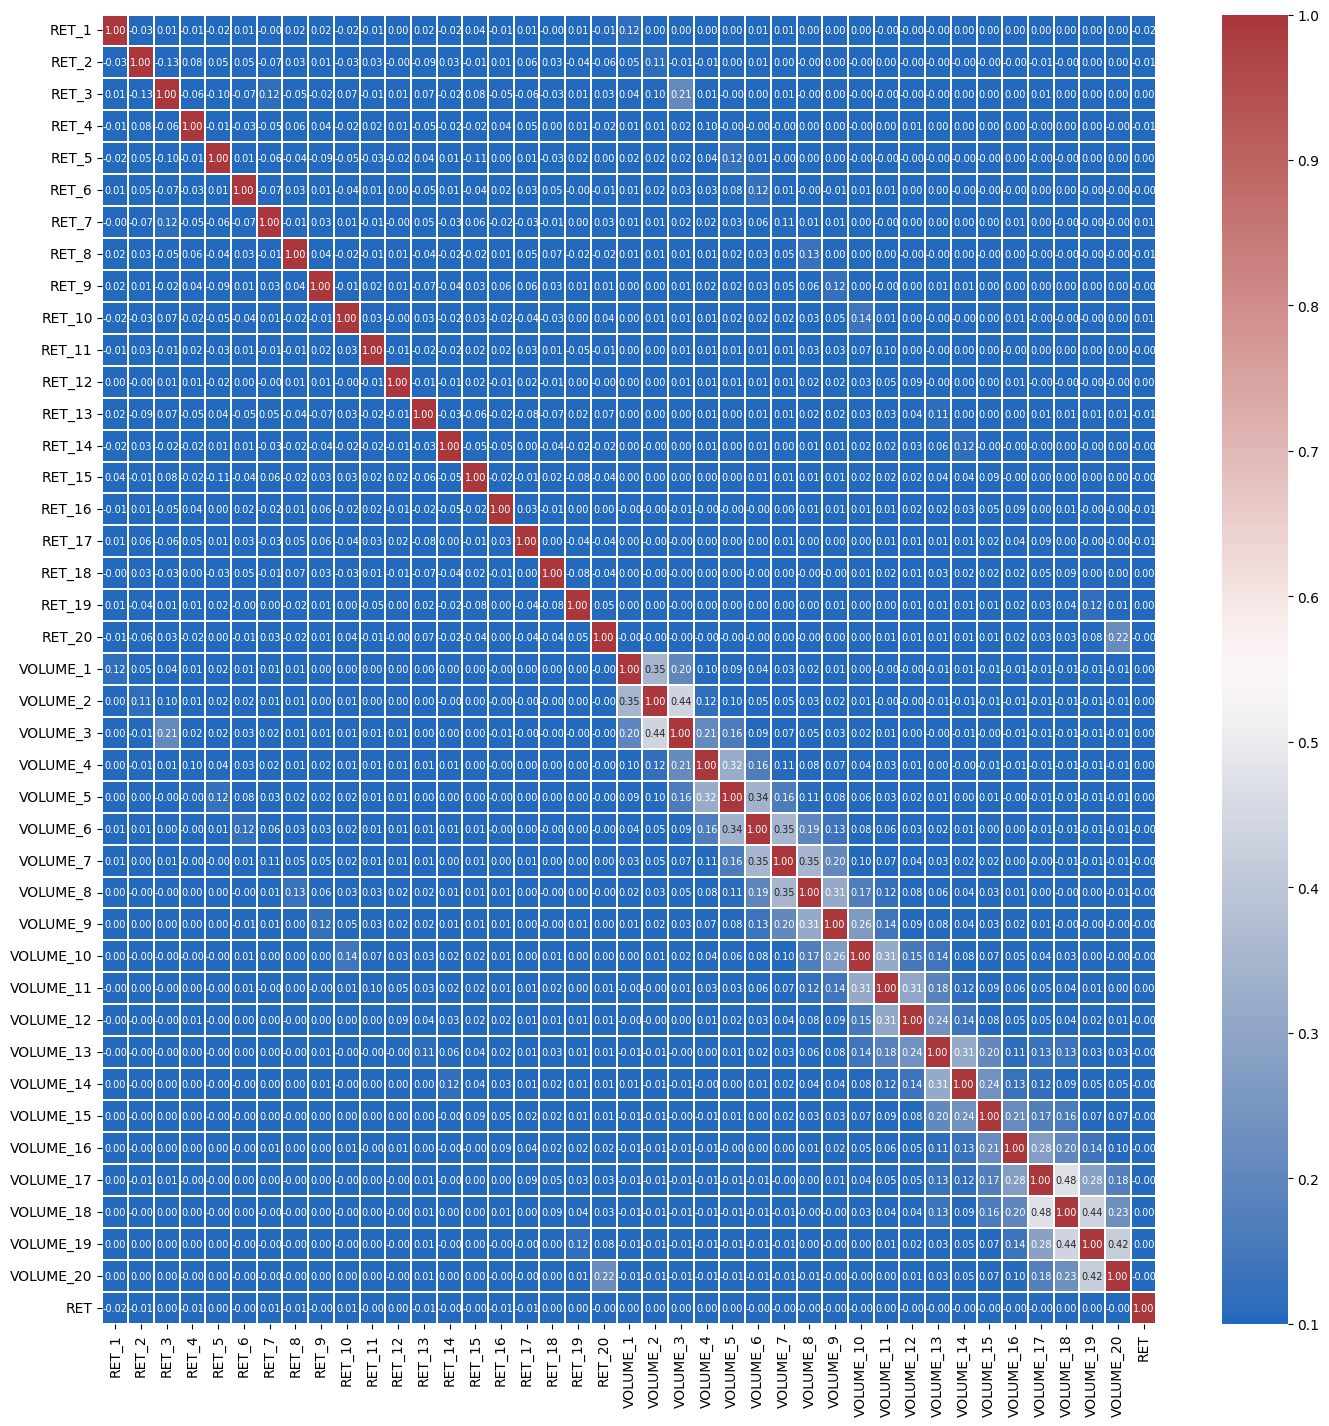

In [ ]:
corr = train[[f'RET_{i}' for i in range(1, 21)] + [f'VOLUME_{i}' for i in range(1, 21)] + ['RET']].corr()
plt.figure(figsize=(17, 17))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=0.1, annot_kws={"size": 7.0}, linewidth=0.2, cmap='vlag', xticklabels=True, yticklabels=True)
plt.show()

As seen in the heatmap, none of the past returns (**RET_1** to **RET_20**) nor past volumes (**VOLUME_1** to **VOLUME_20**) show a strong direct correlation with **RET**.
However, we do a observe a moderate correlation between consecutive volumes, but this does not seem to be the case for the returns.

Before working on feature engineering, we need to make sure we can work on the data.
There is a total of 104,435 rows with at least one missing value, accounting for almost 25% the dataset.
We have two solutions:
- inputting the value with a statistical method (mean, median, or using a more advanced strategy such as nearest neighbor regression or a decision tree regressor)
- dropping these rows

In [ ]:
ret_columns = [f'RET_{i}' for i in range(1, 21)]
volume_columns = [f'VOLUME_{i}' for i in range(1, 21)]

columns_to_check = ret_columns + volume_columns

missing_rows_count = train[columns_to_check].isna().any(axis=1).sum()
print(f"{missing_rows_count} out of {len(train)} rows have at least one missing element, which corresponds to {100 * missing_rows_count / len(train):.2f}% of the dataset.")

104435 out of 418595 rows have at least one missing element, which corresponds to 24.95% of the dataset.


We display below how close the median value of the first return conditioned on different categorical features would be to the *"true"* value. We omit the **STOCK**, **DATE** aggregation as these would only contain a single occurrence per stock, making the median effectively the observed value itself.

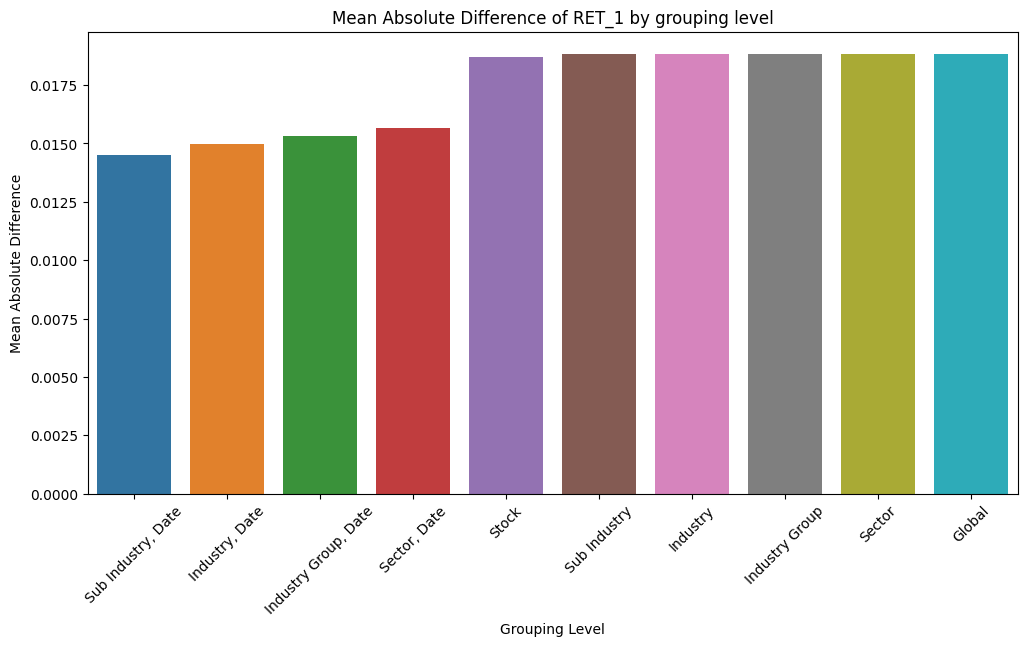

In [ ]:
value = "RET_1"
global_median = train[value].median()

# Compute the medians per category
sector_medians = train.groupby('SECTOR')[value].median()
industry_group_medians = train.groupby('INDUSTRY_GROUP')[value].median()
industry_medians = train.groupby('INDUSTRY')[value].median()
sub_industry_medians = train.groupby('SUB_INDUSTRY')[value].median()
stock_medians = train.groupby('STOCK')[value].median()

# Compute the medians for (SECTOR, DATE), (INDUSTRY_GROUP, DATE), (INDUSTRY, DATE) and ('SUB_INDUSTRY', 'DATE')
sector_date_medians = train.groupby(['SECTOR', 'DATE'])[value].median()
industry_group_date_medians = train.groupby(['INDUSTRY_GROUP', 'DATE'])[value].median()
industry_date_medians = train.groupby(['INDUSTRY', 'DATE'])[value].median()
sub_industry_date_medians = train.groupby(['SUB_INDUSTRY', 'DATE'])[value].median()

# Compute mean absolute difference for each grouping
mean_diffs = {
    'Global': np.abs(train[value] - global_median).mean(),
    'Sector': np.abs(train[value] - train['SECTOR'].map(sector_medians)).mean(),
    'Industry Group': np.abs(train[value] - train['INDUSTRY_GROUP'].map(industry_group_medians)).mean(),
    'Industry': np.abs(train[value] - train['INDUSTRY'].map(industry_medians)).mean(),
    'Sub Industry': np.abs(train[value] - train['SUB_INDUSTRY'].map(sub_industry_medians)).mean(),
    'Stock': np.abs(train[value] - train['STOCK'].map(stock_medians)).mean(),
    'Sector, Date': np.abs(train[value] - train.set_index(['SECTOR', 'DATE']).index.map(sector_date_medians)).mean(),
    'Industry Group, Date': np.abs(train[value] - train.set_index(['INDUSTRY_GROUP', 'DATE']).index.map(industry_group_date_medians)).mean(),
    'Industry, Date': np.abs(train[value] - train.set_index(['INDUSTRY', 'DATE']).index.map(industry_date_medians)).mean(),
    'Sub Industry, Date': np.abs(train[value] - train.set_index(['SUB_INDUSTRY', 'DATE']).index.map(sub_industry_date_medians)).mean(),
}

mean_diffs_df = pd.DataFrame.from_dict(mean_diffs, orient='index', columns=['Difference']).sort_values(by='Difference')

plt.figure(figsize=(12, 6))
sns.barplot(x=mean_diffs_df.index, y=mean_diffs_df['Difference'])
plt.xlabel('Grouping Level')
plt.ylabel('Mean Absolute Difference')
plt.title(f'Mean Absolute Difference of {value} by grouping level')
plt.xticks(rotation=45, ha='center')
plt.show()

The lowest mean absolute differences are found when conditioning on **Sub Industry** + **Date**, **Industry** + **Date**, and **Industry Group** + **Date**, indicating that these groupings provide the closest approximation to the true value of **RET_1**.

The preprocessing code looks as follow:
```python
k = 6 # the period we are processing
ret_columns = [f'RET_{i}' for i in range(1, k)]
for col in ret_columns:
    train[col] = train.groupby(['SUB_INDUSTRY', 'DATE'])[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby(['SUB_INDUSTRY', 'DATE'])[col].transform(lambda x: x.fillna(x.median()))
vol_columns = [f'VOLUME_{i}' for i in range(1, k)]
for col in vol_columns:
    train[col] = train.groupby(['DATE', 'SUB_INDUSTRY'])[col].transform(lambda x: x.fillna(x.median()))
    train[col] = train.groupby(['DATE', 'INDUSTRY'])[col].transform(lambda x: x.fillna(x.median()))
    train[col] = train.groupby(['DATE', 'INDUSTRY_GROUP'])[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby(['DATE', 'SUB_INDUSTRY'])[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby(['DATE', 'INDUSTRY'])[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby(['DATE', 'INDUSTRY_GROUP'])[col].transform(lambda x: x.fillna(x.median()))

columns_to_check = ret_columns + vol_columns
missing_rows_count = train[columns_to_check].isna().any(axis=1).sum()
train.dropna(subset=columns_to_check, inplace=True)
```

Applying this inputation method of replacing missing values with the median conditioned on the granularity shown above led to an accuracy improvement of approximately `0.015%` on validation, which is significant given that the average accuracy hovers around `51.5%`.

## Feature engineering

In this section, we provide explicit definitions of all crafted features used during experimentation.

### 1. Aggregated Statistical Features
We compute several statistical measures (mean, median, standard deviation) of returns at different grouping levels.

- **Mean**:
$$
\text{RET}_{t,group,mean} = \mathbb{E}[\text{RET}_t \mid group]
$$

- **Median**:
$$
\text{RET}_{t,group,median} = \text{median}(\text{RET}_t \mid group)
$$

- **Standard Deviation**:
$$
\text{RET}_{t,group,std} = \sigma(\text{RET}_t \mid group)
$$

where:
- $t$ denotes the shifted return with $t \in \{1,...,20\}$.
- $group$ includes:
    - Single groupings: **DATE**, **SECTOR**, **DATE**, **INDUSTRY_GROUP**, **INDUSTRY**, **SUB_INDUSTRY**
    - Combined groupings: (**DATE, SECTOR**), (**DATE, INDUSTRY_GROUP**), (**SECTOR**, **INDUSTRY_GROUP**)...
    
*We take the RET as a variable here, but also we experiment with the VOLUME.*

### 2. Cumulative Returns and Squared Returns

- **Cumulative Returns**:
$$
\text{CUM-RETURNS}_{k,group} = \sum_{t=1}^{k} \text{RET}_{t,group}
$$
Summarizes recent returns over a short period.
$$
\text{CUM-SQUARED-RETURNS}_{k,group} = \sum_{t=1}^{k} \text{RET}_{t,group}^2
$$
Measures volatility or instability in returns during recent periods. 

### 3. Volatility Features

- **Volume Volatility**:
$$
\text{VOLATILITY-VOLUME}_{t,group} = \sigma(\text{VOLUME}_t \mid group)
$$
Captures volatility of a specific group.

- **Average Volatility**:
$$
\text{ROLLING-STD}_k = \sigma(\text{RET}_t, t = 1,...,k)
$$
Indicates the uncertainty in returns of a stock.

- **Volatility Ratio**:
$$
\text{VOLATILITY-RATIO}_{k,j,group} = \frac{\text{ROLLING-STD}_k}{\text{ROLLING-STD}_{j,group}}
$$
with $j > k$. Compares recent volatility to long-term volatility.

### 4. Normalized Volume Features

- **Z-Score**:
$$
\text{VOL-Z-GROUP}_{t,group} = \frac{\text{VOLUME}_t - \mathbb{E}[\text{VOLUME}_t \mid group]}{\sigma(\text{VOLUME}_t \mid group)}
$$
Similar to a z-test, it highlights unusual volume to a baseline.

### 5. Cross-level Differences

- **Group Difference**:
$$
\text{GROUP-DIFF}_{t,group_1,group_2} = \mathbb{E}[\text{RET}_t \mid group_1] - \mathbb{E}[\text{RET}_t \mid group_2]
$$
where $group_1 \neq group_2$. It evaluates discrepancies between broader and finer group-level returns.

The features that did get me the best results are the following:

In [ ]:
features = ['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'CUM_SQUARED_RETURNS',
 'RET_1_SECTOR_DATE_mean',
 'RET_1_INDUSTRY_GROUP_DATE_mean',
 'RET_1_SECTOR_INDUSTRY_GROUP_mean',
 'SECTOR_INDUSTRY_DIFF',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3']

In [ ]:
# I skip the details in this notebook, it is possible to reproduce the results using train.py
# random_forest = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=123)
# random_forest.fit(X_train, y_train)

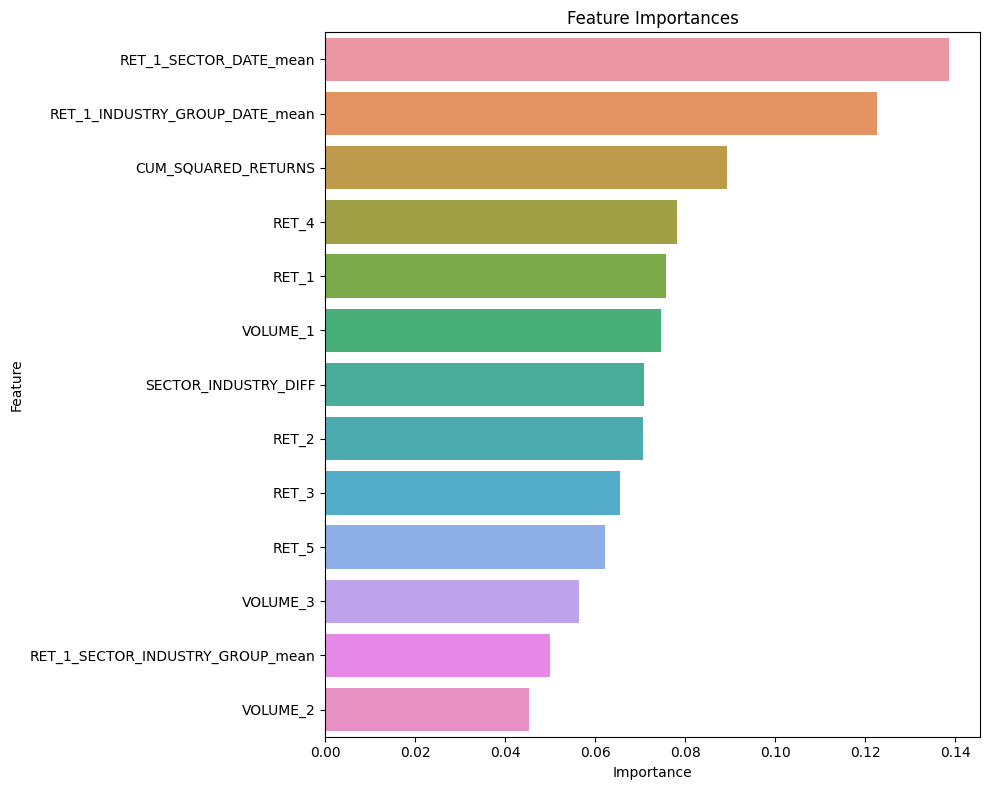

In [ ]:
# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
#     'Importance': xgb.feature_importances_
    'Importance': rf.feature_importances_
#     'Importance': np.mean(importances, axis = 0)
})

# Sort the features by importance for better visualization
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, y='Feature', x='Importance', orient='h')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
pd.read_csv('results.csv', index_col=0)

,file,features,n_estimators,random_seed,depth,rf_mean_accuracy,rf_std_accuracy,xgb_mean_accuracy,xgb_std_accuracy
127,results_17.json,"RET_1,RET_2,RET_3,RET_4,RET_5,RET_1_SECTOR_DAT...",200,42,8,0.516767,0.005963,0.515267,0.006353
160,results_21.json,"RET_1,RET_2,RET_3,RET_4,RET_5,RET_1_SECTOR_DAT...",200,123,8,0.518533,0.007097,0.515546,0.007567
188,results_24.json,"RET_1,RET_2,RET_3,RET_4,RET_5,RET_1_SECTOR_DAT...",200,7,8,0.518595,0.010475,0.517739,0.010494


In [ ]:
pd.read_csv('results.csv', index_col=0).pivot_table(index="features")

,depth,n_estimators,random_seed,rf_mean_accuracy,rf_std_accuracy,xgb_mean_accuracy,xgb_std_accuracy
features,,,,,,,
"RET_1,RET_2,RET_3,RET_4,RET_5,RET_1_SECTOR_DATE_mean,RET_1_SECTOR_INDUSTRY_GROUP_mean,VOLUME_1,VOLUME_2,VOLUME_3,RET_1_INDUSTRY_GROUP_DATE_mean,CUM_SQUARED_RETURNS,SECTOR_INDUSTRY_DIFF",8,200,57.333333,0.517965,0.007845,0.516184,0.008138


### Deep learning solution (experimental)

I show a basic deep learning solution where I was able to obtain an accuracy of `52.3%` on some validation sets. Nevertheless, it remains difficult to work with cross-validation and deep learning in practice.

In [ ]:
class BCEWithLogitsLossLabelSmoothing(nn.Module):
    def __init__(self, label_smoothing=0.0):
        super(BCEWithLogitsLossLabelSmoothing, self).__init__()
        assert 0 <= label_smoothing < 1, "label_smoothing must be between 0 and 1"
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        if self.label_smoothing > 0:
            smooth_pos = 1.0 - self.label_smoothing
            smooth_targets = targets * smooth_pos + (1 - targets) * (self.label_smoothing)
        else:
            smooth_targets = targets

        loss = self.loss_fn(logits, smooth_targets)
        return loss

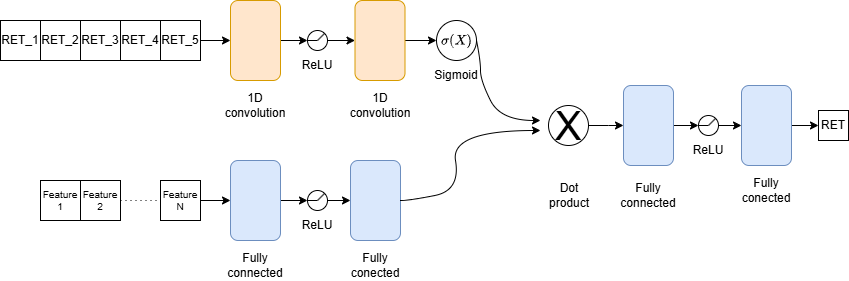
<center><b>Figure: Deep learning architecture</b></center>

The figure shows a neural network combining temporal returns and handcrafted features. The top branch processes **RET_1** to **RET_5** using 1D convolutions and the bottom branch applies fully connected layers to additional features. The two branches are merged with Gated Linear Unit (GLU). The output is passed through fully connected layers to predict **RET**.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
        self.conv_dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(len(features) - 5, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.25)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.glu = nn.GLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        returns = x[:, :, :5]
        others = x[:, 0, 5:]
        returns = self.relu(self.conv1(returns))
        returns = self.conv_dropout(returns)
        returns = self.conv2(returns)
        returns = self.conv_dropout(returns)
        others = self.relu(self.fc1(others))
        others = self.dropout(others)
        others = self.fc2(others)
        others = self.dropout(others)
        x = torch.concatenate([others.view(x.shape[0], -1), returns.view(x.shape[0], -1)], axis = -1)
        x = self.relu(self.fc3(self.glu(x)))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))
        return x.squeeze(-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Z-score the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Create DataLoader for batch processing
batch_size = 192
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
# criterion = BCEWithLogitsLossLabelSmoothing(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.995)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
#     scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            y_pred.extend(outputs.round().cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/20, Train Loss: 0.6925, Validation Loss: 0.6918, Accuracy: 0.5018
Epoch 2/20, Train Loss: 0.6916, Validation Loss: 0.6904, Accuracy: 0.5101
Epoch 3/20, Train Loss: 0.6903, Validation Loss: 0.6891, Accuracy: 0.5042
Epoch 4/20, Train Loss: 0.6893, Validation Loss: 0.6887, Accuracy: 0.5153
Epoch 5/20, Train Loss: 0.6887, Validation Loss: 0.6877, Accuracy: 0.5166
Epoch 6/20, Train Loss: 0.6878, Validation Loss: 0.6869, Accuracy: 0.5167
Epoch 7/20, Train Loss: 0.6871, Validation Loss: 0.6867, Accuracy: 0.5168
Epoch 8/20, Train Loss: 0.6868, Validation Loss: 0.6861, Accuracy: 0.5237
Epoch 9/20, Train Loss: 0.6862, Validation Loss: 0.6856, Accuracy: 0.5156
Epoch 10/20, Train Loss: 0.6858, Validation Loss: 0.6847, Accuracy: 0.5167
Epoch 11/20, Train Loss: 0.6855, Validation Loss: 0.6850, Accuracy: 0.5132
Epoch 12/20, Train Loss: 0.6851, Validation Loss: 0.6835, Accuracy: 0.5192
Epoch 13/20, Train Loss: 0.6849, Validation Loss: 0.6829, Accuracy: 0.5219
Epoch 14/20, Train Loss: 0.6845, V

## Some things I tried that did not work:
- Using an autoregressive model on the returns: although the returns appear to be normally distributed, they are, for some, non-stationary due to heteroskedasticity. In addition, the sampling frequency, may not be suitable either.
- Using second order features such as squared returns, interactions of returns, weighted average or zero crossing count.

## Miscellaneous ideas
- One could leverage contrastive learning to match embeddings of similar industries.
- Other architecture could be studied. For instance, we could experiment with we could explore feature pramid networks to capture financial data at different scales.
- Use a multimodal architecture between financial data and time series data



I believe there is definitely room for improvement by incorporating more features and exploring deep learning approaches.

After submitting my solution on https://challengedata.ens.fr, I obtained a public score of 51.60%.